In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import time
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.models import Model

from Data_processing_functions import *
from Pix2Pix_model import *


In [61]:
from tensorflow.keras import backend as K
import gc

# Clear TensorFlow/Keras session
K.clear_session()

# Collect garbage
gc.collect()

# Proceed with loading or creating a new model

0

## Dataset for Testing

In [4]:
# Load and preprocess image
def load_and_preprocess_image(image_path, target_size, is_grayscale=False):
    img = tf.io.read_file(image_path)
    channels = 1 if is_grayscale else 3
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img

# Convert RGB image to LAB using TensorFlow
def convert_to_lab(image):
    image_np = image.numpy() * 255.0  # Convert to 0-255 range for OpenCV
    image_np = image_np.astype(np.uint8)
    lab_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    lab_image = lab_image.astype(np.float32) / 255.0  # Normalize to 0-1
    return lab_image

# Wrapper to use convert_to_lab in TensorFlow pipeline
def preprocess_lab_image(image):
    lab_image = tf.py_function(func=convert_to_lab, inp=[image], Tout=tf.float32)
    lab_image.set_shape([None, None, 3])  # Set shape to avoid shape issues in TensorFlow
    return lab_image

# Load and preprocess images
def load_and_preprocess(gray_path, lab_path, target_size):
    gray_img = load_and_preprocess_image(gray_path, target_size, is_grayscale=True)
    rgb_img = load_and_preprocess_image(lab_path, target_size, is_grayscale=False)
    lab_img = preprocess_lab_image(rgb_img)
    return gray_img, lab_img

# Create dataset
def create_dataset(gray_image_paths, lab_image_paths, target_size=(256, 256), batch_size=32):
    gray_image_paths = tf.constant(gray_image_paths, dtype=tf.string)
    lab_image_paths = tf.constant(lab_image_paths, dtype=tf.string)
    
    # Define the dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices((gray_image_paths, lab_image_paths))
    
    # Map the dataset to preprocess images
    dataset = dataset.map(lambda gray_path, lab_path: tf.py_function(
        func=lambda x, y: load_and_preprocess(x, y, target_size),
        inp=[gray_path, lab_path],
        Tout=[tf.float32, tf.float32]
    ), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Extract edges from an image
def extract_edges(image):
    edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200)
    return edges / 255.0

# Process a single grayscale image: extract edges and combine with the original image
def process_single_image(gray_image):
    edges = extract_edges(gray_image)
    edges = tf.convert_to_tensor(edges, dtype=tf.float32)[..., tf.newaxis]
    combined = tf.concat([tf.expand_dims(gray_image, axis=-1), edges], axis=-1)
    return combined

# Combine grayscale image with edges
def combine_gray_and_edges(gray_img, lab_img):
    combined_images = []
    for i in range(gray_img.shape[0]):
        single_gray = gray_img[i].numpy()  # Convert to NumPy array
        combined_images.append(process_single_image(single_gray))
    combined_batch = tf.stack(combined_images, axis=0)
    return combined_batch, lab_img

# Create dataset with edges
def create_dataset_with_edges(original_dataset):
    dataset_with_edges = original_dataset.map(
        lambda gray_img, lab_img: tf.py_function(
            func=lambda x, y: combine_gray_and_edges(x, y),
            inp=[gray_img, lab_img],
            Tout=[tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset_with_edges



In [5]:
# Define Data Directory
dir_path = 'data'
color_dir = os.path.join(dir_path, 'train_color')
black_dir = os.path.join(dir_path, 'train_black')

# List all images
color_images_paths = glob.glob(os.path.join(color_dir, '*.jpg'))
black_images_paths = glob.glob(os.path.join(black_dir, '*.jpg'))

# Create the original dataset
dataset = create_dataset(black_images_paths, color_images_paths, target_size=(256, 256))

# dataset_with_edges = create_dataset_with_edges(dataset) we can experimint with it later

# Take only 2 batches for the whole dataset
dataset = dataset.take(2)

# Split dataset into training and validation (e.g., 1 batch for training, 1 batch for validation)
train_size = 1  # Number of batches for training
val_size = 1    # Number of batches for validation

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)



In [4]:
# Print dataset shapes for verification
for gray_img, lab_img in train_dataset.take(1):
    print("Train Dataset Shapes:")
    print(f"Input Image Shape: {gray_img.shape}")
    print(f"Target Shape: {lab_img.shape}")

for gray_img, lab_img in val_dataset.take(1):
    print("Validation Dataset Shapes:")
    print(f"Input Image Shape: {gray_img.shape}")
    print(f"Target Shape: {lab_img.shape}")

Train Dataset Shapes:
Input Image Shape: (32, 256, 256, 1)
Target Shape: (32, 256, 256, 3)
Validation Dataset Shapes:
Input Image Shape: (32, 256, 256, 1)
Target Shape: (32, 256, 256, 3)


## testing

In [1]:
# import tensorflow as tf
# import numpy as np
# import cv2
# import os
# import time
# import glob
# from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU, ReLU
# from tensorflow.keras.models import Model
# import matplotlib.pyplot as plt

# Define the downsampling and upsampling blocks
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(hyperparams['dropout_rate']))
    result.add(tf.keras.layers.ReLU())
    return result

# Define the Generator model
def Generator(hyperparams):
    inputs = tf.keras.layers.Input(shape=hyperparams['input_shape'])

    down_stack = [downsample(hyperparams['initial_filters'] * (2 ** i), hyperparams['kernel_size'], apply_batchnorm=hyperparams['batch_norm']) for i in range(hyperparams['num_layers'])]
    up_stack = [upsample(hyperparams['initial_filters'] * (2 ** i), hyperparams['kernel_size'], apply_dropout=hyperparams['dropout']) for i in range(hyperparams['num_layers']-1, 0, -1)]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, hyperparams['kernel_size'], strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.concatenate([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


# Define the Discriminator model
def Discriminator(hyperparams):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=hyperparams['input_shape'], name='input_image')
    tar = tf.keras.layers.Input(shape=[*hyperparams['input_shape'][:2], 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (hyperparams['lambda_l1'] * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# PSNR metric
def psnr_metric(y_true, y_pred):
    max_pixel = 1.0
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=max_pixel)
    return tf.reduce_mean(psnr_value)

# Training step function
def train_step(generator, discriminator, input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

# Define the evaluation function
def evaluate_model(dataset, generator, discriminator):
    total_gen_loss = 0
    total_psnr = 0
    num_batches = 0
    for input_image, target in dataset:
        gen_output = generator(input_image, training=False)
        disc_generated_output = discriminator([input_image, gen_output], training=False)
        gen_total_loss, _, _ = generator_loss(disc_generated_output, gen_output, target)
        total_gen_loss += gen_total_loss

        # Compute PSNR
        psnr_value = psnr_metric(target, gen_output)
        total_psnr += psnr_value
        num_batches += 1
    avg_gen_loss = total_gen_loss / num_batches
    avg_psnr = total_psnr / num_batches
    return avg_gen_loss, avg_psnr

# Training function with validation loss
def model_fit(train_ds, val_ds, hyperparams, checkpoint, checkpoint_prefix):
    gen_losses = []
    disc_losses = []
    val_gen_losses = []
    val_psnrs = []

    generator = Generator(hyperparams)
    discriminator = Discriminator(hyperparams)

    # Define the optimizers
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'], beta_1=hyperparams['beta_1'])
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'], beta_1=hyperparams['beta_1'])

    for epoch in range(hyperparams['epochs']):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0

        # Progress bar
        progbar = tf.keras.utils.Progbar(len(train_ds), stateful_metrics=['loss'])
        
        for step, (input_image, target) in enumerate(train_ds):
            gen_total_loss, disc_loss = train_step(generator, discriminator, input_image, target)
            epoch_gen_loss += gen_total_loss
            epoch_disc_loss += disc_loss

            # Update progress bar
            progbar.update(step + 1, [('gen_loss', gen_total_loss), ('disc_loss', disc_loss)])

        gen_losses.append(epoch_gen_loss / len(train_ds))
        disc_losses.append(epoch_disc_loss / len(train_ds))

        val_gen_loss, val_psnr = evaluate_model(val_ds, generator, discriminator)
        val_gen_losses.append(val_gen_loss)
        val_psnrs.append(val_psnr)

        # Save checkpoint
        checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_losses[-1]}, Disc Loss: {disc_losses[-1]}, Val Gen Loss: {val_gen_losses[-1]}, Val PSNR: {val_psnrs[-1]}, Time: {time.time() - start}')

    return gen_losses, disc_losses, val_gen_losses, val_psnrs

# Visualize losses
def visualize_losses(gen_losses, disc_losses, val_gen_losses, val_psnrs):
    plt.figure(figsize=(12, 6))
    
    # Plot Generator and Discriminator Losses
    plt.subplot(1, 2, 1)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.plot(val_gen_losses, label='Validation Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Losses')

    # Plot Validation PSNR
    plt.subplot(1, 2, 2)
    plt.plot(val_psnrs, label='Validation PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()
    plt.title('Validation PSNR')

    plt.tight_layout()
    plt.show()


   


In [2]:
# Example hyperparameters for testing
# Hyperparameters
hyperparams = {
    'initial_filters': 64,         # Starting number of filters in the first layer
    'kernel_size': 4,              # Size of the convolutional kernel
    'num_layers': 8,               # Number of convolutional layers
    'dropout_rate': 0.5,           # Dropout rate for regularization
    'batch_norm': True,            # Use of batch normalization
    'lambda_l1': 100,              # L1 regularization parameter
    'learning_rate': 2e-4,         # Learning rate for the optimizer
    'beta_1': 0.5,                 # Beta1 hyperparameter for the Adam optimizer
    'batch_size': 1,               # Batch size for training
    'epochs': 150,                 # Number of epochs for training
    'dropout': True,               # Whether to use dropout
    'input_shape': (256, 256, 1)   # Input shape of the images (3 channels for RGB)
}



# Initialize models
generator = Generator(hyperparams)
discriminator = Discriminator(hyperparams)

# Print model summaries
print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 128, 128, 64)      │           1,280 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 64, 64, 128)       │         131,584 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 32, 32, 256)       │         525,312 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_3 (Sequential)     │ (None, 16, 16, 512)       │       2,099,200 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_4 (Sequential)     │ (None, 8, 8, 1024)        │       8,392,704 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_5 (Sequential)     │ (None, 4, 4, 2048)        │      33,562,624 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_6 (Sequential)     │ (None, 8, 8, 2048)        │      67,117,056 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 8, 8, 3072)        │               0 │ sequential_6[0][0],        │
│                               │                           │                 │ sequential_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_7 (Sequential)     │ (None, 16, 16, 1024)      │      50,335,744 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 16, 16, 1536)      │               0 │ sequential_7[0][0],        │
│                               │                           │                 │ sequential_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_8 (Sequential)     │ (None, 32, 32, 512)       │      12,584,960 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 32, 32, 768)       │               0 │ sequential_8[0][0],        │
│                               │                           │                 │ sequential_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_9 (Sequential)     │ (None, 64, 64, 256)       │       3,146,752 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 64, 64, 384)       │               0 │ sequential_9[0][0],        │
│                               │                           │                 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 178,693,379 (681.66 MB)

 Trainable params: 178,677,379 (681.60 MB)

 Non-trainable params: 16,000 (62.50 KB)


Discriminator Summary:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ target_image (InputLayer)     │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_5 (Concatenate)   │ (None, 256, 256, 4)       │               0 │ input_image[0][0],         │
│                               │                           │                 │ target_image[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_11 (Sequential)    │ (None, 128, 128, 64)      │           4,096 │ concatenate_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_12 (Sequential)    │ (None, 64, 64, 128)       │         131,584 │ sequential_11[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_13 (Sequential)    │ (None, 32, 32, 256)       │         525,312 │ sequential_12[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 34, 34, 256)       │               0 │ sequential_13[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 31, 31, 512)       │       2,097,152 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 31, 31, 512)       │           2,048 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU)     │ (None, 31, 31, 512)       │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 33, 33, 512)       │               0 │ leaky_re_lu_9[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 30, 30, 1)         │           8,193 │ zero_padding2d_1[0][0]     │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,768,385 (10.56 MB)

 Trainable params: 2,766,593 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - gen_loss: 55.0270 - disc_loss: 1.7323
Epoch 1, Gen Loss: 55.0269775390625, Disc Loss: 1.7322580814361572, Val Gen Loss: 50.322879791259766, Val PSNR: 5.677682876586914, Time: 104.67278337478638
1/1 ━━━━━━━━━━━━━━━━━━━━ 96s 96s/step - gen_loss: 50.9360 - disc_loss: 4.0899
Epoch 2, Gen Loss: 50.93601608276367, Disc Loss: 4.089873790740967, Val Gen Loss: 50.21650695800781, Val PSNR: 5.688100814819336, Time: 118.08128619194031
1/1 ━━━━━━━━━━━━━━━━━━━━ 92s 92s/step - gen_loss: 46.7824 - disc_loss: 1.7723
Epoch 3, Gen Loss: 46.78242874145508, Disc Loss: 1.7722623348236084, Val Gen Loss: 50.17636489868164, Val PSNR: 5.692882537841797, Time: 116.3330249786377
1/1 ━━━━━━━━━━━━━━━━━━━━ 94s 94s/step - gen_loss: 42.7526 - disc_loss: 2.3151
Epoch 4, Gen Loss: 42.75261688232422, Disc Loss: 2.3151073455810547, Val Gen Loss: 50.598182678222656, Val PSNR: 5.621923446655273, Time: 115.36475491523743
1/1 ━━━━━━━━━━━━━━━━━━━━ 71s 71s/step - gen_loss: 38.1898 - disc_

Epoch 31, Gen Loss: 11.211966514587402, Disc Loss: 0.32719236612319946, Val Gen Loss: 32.0545539855957, Val PSNR: 7.905303001403809, Time: 119.68429446220398
1/1 ━━━━━━━━━━━━━━━━━━━━ 107s 107s/step - gen_loss: 11.3396 - disc_loss: 0.3164
Epoch 32, Gen Loss: 11.339616775512695, Disc Loss: 0.3164255917072296, Val Gen Loss: 30.64706802368164, Val PSNR: 8.440011024475098, Time: 129.40130639076233
1/1 ━━━━━━━━━━━━━━━━━━━━ 109s 109s/step - gen_loss: 11.4563 - disc_loss: 0.2937
Epoch 33, Gen Loss: 11.456276893615723, Disc Loss: 0.2937440276145935, Val Gen Loss: 30.52181625366211, Val PSNR: 8.292173385620117, Time: 131.56275939941406
1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step - gen_loss: 11.2190 - disc_loss: 0.3246
Epoch 34, Gen Loss: 11.219013214111328, Disc Loss: 0.3245539367198944, Val Gen Loss: 29.688329696655273, Val PSNR: 8.561124801635742, Time: 128.67519998550415
1/1 ━━━━━━━━━━━━━━━━━━━━ 108s 108s/step - gen_loss: 10.9233 - disc_loss: 0.3851
Epoch 35, Gen Loss: 10.923301696777344, Disc Lo

Epoch 50, Gen Loss: 9.213472366333008, Disc Loss: 1.0433604717254639, Val Gen Loss: 30.56499481201172, Val PSNR: 9.780706405639648, Time: 128.93509817123413


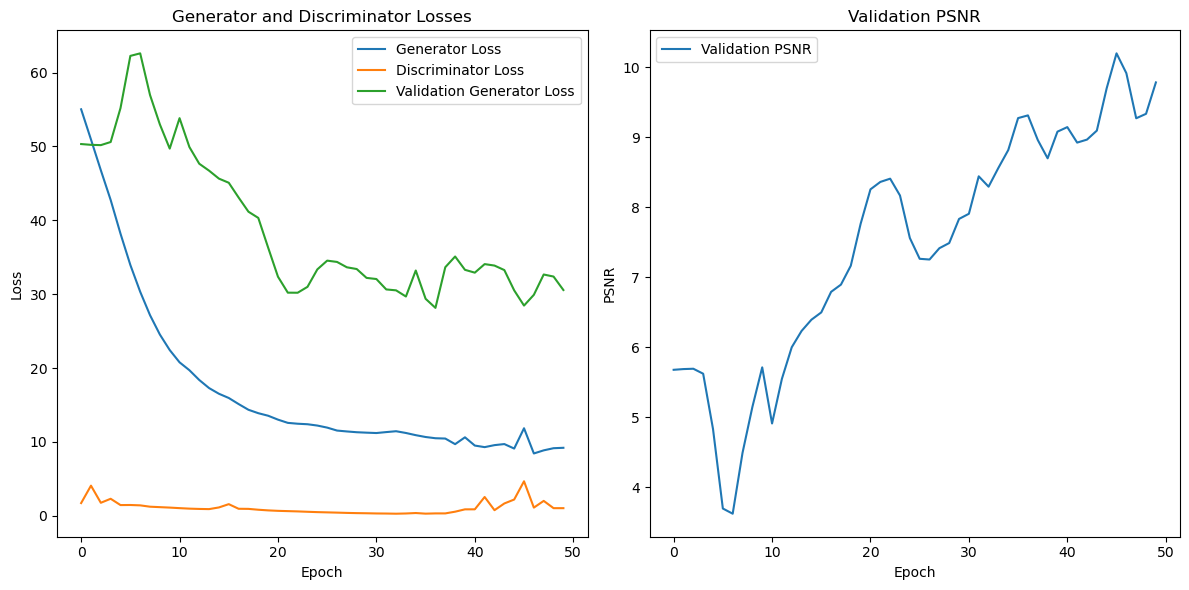

In [6]:
# Define the optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'], beta_1=hyperparams['beta_1'])
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'], beta_1=hyperparams['beta_1'])

# Define the checkpoint directory
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Restore the latest checkpoint if it exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Restored from checkpoint: {latest_checkpoint}")
else:
    print("Starting fresh training")

# Train the model
gen_losses, disc_losses, val_gen_losses, val_psnrs = model_fit(train_dataset, val_dataset, hyperparams, checkpoint, checkpoint_prefix)

# Save the models
generator.save('pix2pix_model_generator.h5')
discriminator.save('pix2pix_model_discriminator.h5')

# Visualize losses
visualize_losses(gen_losses, disc_losses, val_gen_losses, val_psnrs)

In [7]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt

# Load and preprocess image
def load_and_preprocess_image(image_path, target_size, is_grayscale=False):
    img = tf.io.read_file(image_path)
    channels = 1 if is_grayscale else 3
    img = tf.image.decode_jpeg(img, channels=channels)
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img

# Convert RGB image to LAB using TensorFlow
def convert_to_lab(image):
    image_np = image.numpy() * 255.0  # Convert to 0-255 range for OpenCV
    image_np = image_np.astype(np.uint8)
    lab_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    lab_image = lab_image / 255.0  # Normalize to 0-1
    return lab_image

# Wrapper to use convert_to_lab in TensorFlow pipeline
def preprocess_lab_image(image):
    lab_image = tf.py_function(func=convert_to_lab, inp=[image], Tout=tf.float32)
    lab_image.set_shape([None, None, 3])  # Set shape to avoid shape issues in TensorFlow
    return lab_image

# Load and preprocess images
def load_and_preprocess(gray_path, lab_path, target_size):
    gray_img = load_and_preprocess_image(gray_path, target_size, is_grayscale=True)
    rgb_img = load_and_preprocess_image(lab_path, target_size, is_grayscale=False)
    lab_img = preprocess_lab_image(rgb_img)
    return gray_img, lab_img

# Create dataset for test images
def create_test_dataset(gray_image_paths, target_size=(256, 256), batch_size=32):
    gray_image_paths = tf.constant(gray_image_paths, dtype=tf.string)
    
    # Define the dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(gray_image_paths)
    
    # Map the dataset to preprocess images
    dataset = dataset.map(lambda gray_path: load_and_preprocess_image(gray_path, target_size, is_grayscale=True), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Define directories
black_test_dir = 'data/test_black'  # Update with your actual path
color_test_dir = 'data/test_color'   # Update with your actual path

# Load image paths
black_images_test_paths = glob.glob(os.path.join(black_test_dir, '*.jpg'))[:5]
color_images_test_paths = glob.glob(os.path.join(color_test_dir, '*.jpg'))[:5]

# Ensure these paths are not empty
assert len(black_images_test_paths) > 0, "No black and white test images found."
assert len(color_images_test_paths) > 0, "No color test images found."

# Create the test dataset
test_dataset = create_test_dataset(black_images_test_paths, target_size=(256, 256))

# Load the trained generator model
generator = tf.keras.models.load_model('pix2pix_model_generator.h5')

# Function to generate colorful images
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction

# Function to show images
def show_images(gray_images, color_images, num_images=5):
    plt.figure(figsize=(18, 8))

    for i in range(num_images):
        # Display generated color images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(gray_images[i]), cmap='gray')
        plt.axis('off')
        plt.title('Generated Colorful Image')

        # Display original color image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(color_images[i]))
        plt.axis('off')
        plt.title('Original Color Image')

    plt.show()

# Iterate through the test dataset and generate colorful images
generated_images_list = []
original_images_list = []

for gray_img_batch in test_dataset:
    generated_images = generate_images(generator, gray_img_batch)
    
    # Since test_dataset might be batched, take first batch
    for i in range(generated_images.shape[0]):
        generated_images_list.append(generated_images[i])

        # Match the color image paths to generated images
        original_color_img_path = color_images_test_paths[i]
        original_color_img = load_and_preprocess_image(original_color_img_path, target_size=(256, 256), is_grayscale=False)
        original_images_list.append(original_color_img)

# Display images using the defined function
show_images(generated_images_list, original_images_list, num_images=5)


AttributeError: in user code:

    File "C:\Users\mohds\AppData\Local\Temp\ipykernel_9636\3034310827.py", line 39, in None  *
        lambda gray_path: load_and_preprocess_image(gray_path.numpy(), target_size, is_grayscale=True)

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [ ]:
# Iterate through the test dataset and generate colorful images
generated_images_list = []
original_images_list = []

for gray_img_batch, color_img_path in zip(test_dataset, color_images_paths):
    generated_images = generate_images(generator, gray_img_batch)
    
    for i in range(generated_images.shape[0]):
        generated_images_list.append(generated_images[i])

        original_color_img = load_and_preprocess_image(color_img_path, target_size=(256, 256), is_grayscale=False)
        original_images_list.append(original_color_img)

# Display images using the defined function
show_images(generated_images_list, original_images_list, num_images=5)